In [2]:
import pandas as pd
pd.set_option('precision', 3)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [15]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/ensemble_202110/"

In [4]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
# foodprice_df = pd.read_csv("./data_files/food_cpi.csv")
# foodprice_df = foodprice_df.set_index("REF_DATE")
# foodprice_df.index = pd.DatetimeIndex(foodprice_df.index)
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3
...,...,...,...,...,...,...,...,...,...
2021-05-01,157.8,146.6,147.6,163.5,156.6,143.9,175.4,141.6,153.8
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4
2021-07-01,157.9,146.4,146.6,165.2,157.6,141.7,180.9,141.9,154.8


In [5]:
experiment_names = ["nbeatsfredvars_202110", "nbeats_202110", "prophet_202110"]
# experiment_names = ["nbeats_202110", "prophet_202110"]
report_sim_dates = ["2015-07-01", "2016-07-01", "2017-07-01", "2018-07-01", "2019-07-01", "2020-07-01"]
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

In [6]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}

In [7]:
ex_name = "nbeats_202110"
sim_date = "2017-07-01"
fc = pd.read_csv(f"./output/{ex_name}/forecasts_{sim_date}.csv", index_col="REF_DATE")
fc.index = pd.DatetimeIndex(fc.index)
fc

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
2017-08-01,153.709,135.804,138.035,146.632,144.145,136.605,157.434,135.669,133.580
2017-09-01,153.161,135.938,137.329,146.710,143.855,134.905,159.193,135.116,126.789
2017-10-01,151.943,133.658,136.182,146.055,142.547,134.216,157.092,133.985,126.558
2017-11-01,152.833,135.240,136.894,147.329,143.807,136.246,158.297,134.947,130.641
2017-12-01,153.270,134.853,136.692,148.907,145.633,138.743,160.036,134.949,137.026
2018-01-01,155.047,136.309,137.341,148.939,146.552,139.821,160.596,135.808,139.693
2018-02-01,153.534,136.422,136.852,148.660,146.041,139.651,159.306,136.616,140.712
2018-03-01,154.664,136.844,137.627,148.802,145.421,139.071,160.523,136.818,140.267
2018-04-01,154.002,135.827,137.842,149.567,146.662,139.672,161.095,136.898,140.444


In [8]:
def get_forecast_df(food_category, experiment_names, experiment_date):

    forecasts = []

    for ex_name in experiment_names:
        fc_df = pd.read_csv(f"./output/{ex_name}/forecasts_{experiment_date}.csv")
        if "REF_DATE" in fc_df.columns:
            fc_df = fc_df.set_index("REF_DATE")
        else:
            fc_df = fc_df.set_index("Unnamed: 0")
        fc_df.index = pd.DatetimeIndex(fc_df.index)
        fc_series = fc_df[food_category]
        fc_series = fc_series.rename(ex_name)
        forecasts.append(fc_series)

    return pd.concat(forecasts, axis=1)

In [9]:
get_forecast_df("Meat", experiment_names, "2017-07-01")

,nbeatsfredvars_202110,nbeats_202110,prophet_202110
2017-08-01,157.768,157.434,164.660
2017-09-01,157.912,159.193,165.075
2017-10-01,159.119,157.092,164.948
2017-11-01,158.290,158.297,165.478
2017-12-01,157.527,160.036,165.636
2018-01-01,159.626,160.596,166.210
2018-02-01,159.230,159.306,166.874
2018-03-01,159.800,160.523,167.374
2018-04-01,161.213,161.095,167.762
2018-05-01,156.989,160.859,168.554


In [10]:
def eval_mean_forecast(foodprice_df, food_category, experiment_date, valid_dates):
      
    valid_series = foodprice_df.loc[valid_dates][food_category]                                 # Select the validation data. 
    all_forecasts = get_forecast_df(food_category, experiment_names, experiment_date)       # Produce the validation period forecast.
    mean_forecast = all_forecasts.mean(axis=1)
    std_forecast =  all_forecasts.std(axis=1)

    valid_metrics = {metric_name: metric_fn(y_true=valid_series,                        # Compute validation metrics. 
                                      y_pred=mean_forecast) for metric_name, metric_fn in metrics.items()}

    return valid_series, mean_forecast, std_forecast, valid_metrics

## Ensemble and evaluate forecasts

In [11]:
all_valid_metrics = {}
all_forecasts = {}

for report_sim_date in report_sim_dates:

    food_forecasts = {}
    food_scores = {}

    for category in food_categories:
        actual, fc, fc_std, scores = eval_mean_forecast(foodprice_df, category, date, sim_valid_dates[date])
        food_scores[category] = scores
        food_forecasts[category] = fc
        
    all_valid_metrics[report_sim_date] = food_scores
    all_forecasts[report_sim_date] = food_forecasts

In [16]:
valid_metrics_concat = {}

all_valid_metrics.keys()

for report_date, valid_scores in all_valid_metrics.items():
    valid_metrics_concat[report_date] = pd.DataFrame(valid_scores).T
index = valid_metrics_concat[report_date].index
columns = valid_metrics_concat[report_date].columns
scores = [df.values for date, df in valid_metrics_concat.items()]
mean_scores = pd.DataFrame(np.array(scores).mean(axis=0), index=index, columns=columns)
mean_scores.to_csv(f"{output_path}/mean_fc_valid_metrics.csv")
mean_scores

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-0.432,1.145,0.007,2.194,1.481
Dairy products and eggs,-2.562,4.512,0.031,24.882,4.988
"Fish, seafood and other marine products",-4.596,3.121,0.022,11.114,3.334
Food purchased from restaurants,0.157,1.372,0.008,2.345,1.531
Food,0.537,1.006,0.006,1.492,1.221
"Fruit, fruit preparations and nuts",-0.829,1.708,0.012,5.217,2.284
Meat,0.226,3.062,0.017,19.820,4.452
Other food products and non-alcoholic beverages,0.205,1.897,0.013,4.723,2.173
Vegetables and vegetable preparations,-1.602,4.911,0.032,39.567,6.290


## Visualize All Forecasts

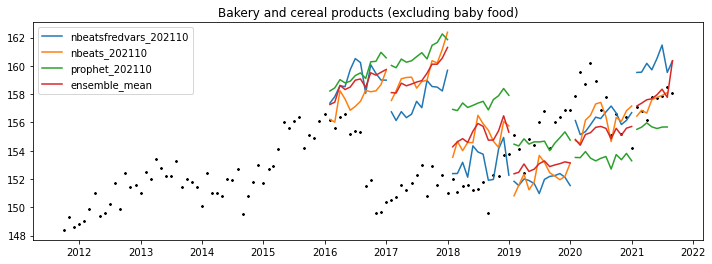

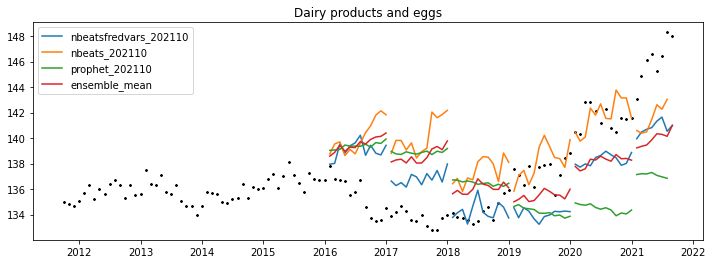

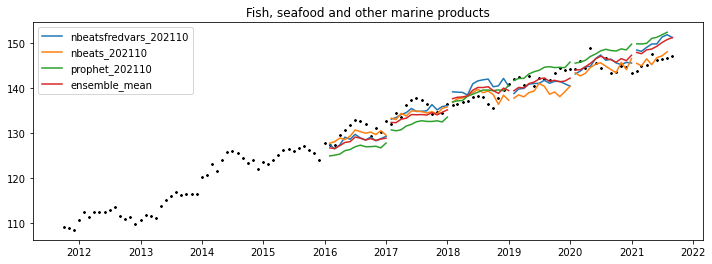

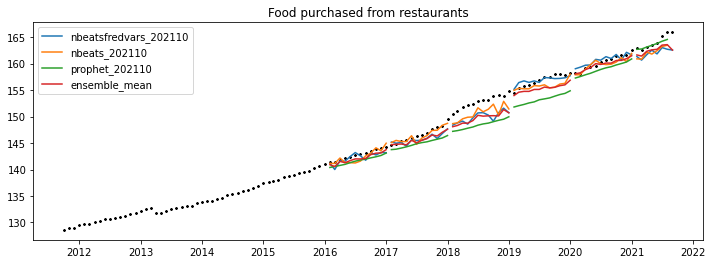

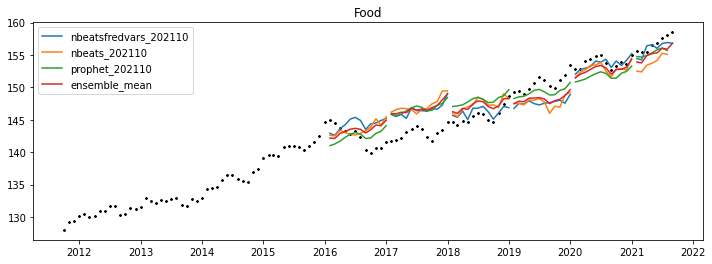

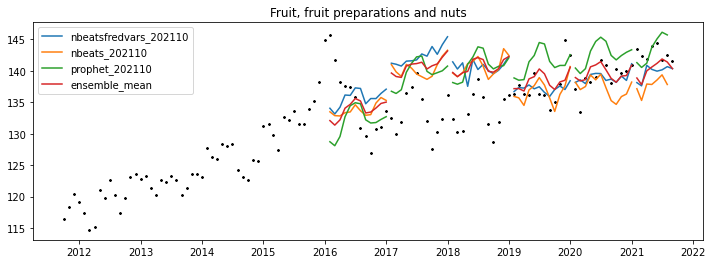

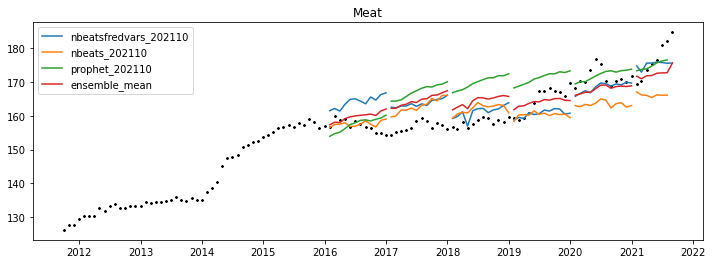

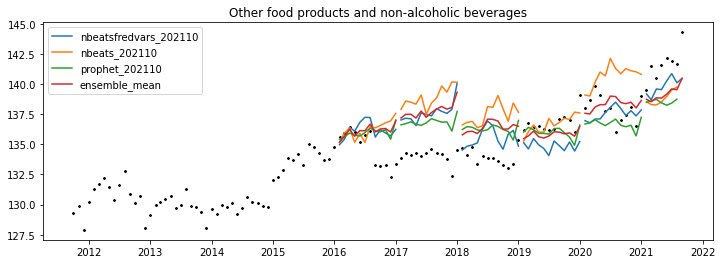

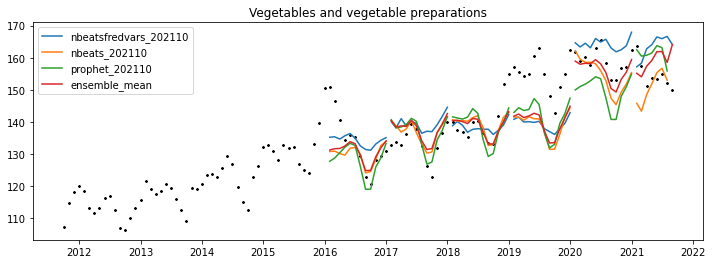

In [19]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, experiment_names, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index > pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index <= pd.to_datetime(date) + pd.DateOffset(months=18)]
        all_forecasts = all_forecasts.assign(ensemble_mean=all_forecasts.mean(axis=1))

        ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=1)
        for index, col in enumerate(all_forecasts):
            if d_index < 1:
                ax.plot(all_forecasts[col], color=f"C{index}", label=col)
            else:
                ax.plot(all_forecasts[col], color=f"C{index}")


    plt.title(category)
    plt.legend()
    plt.show()


## Visualize Mean Forecasts

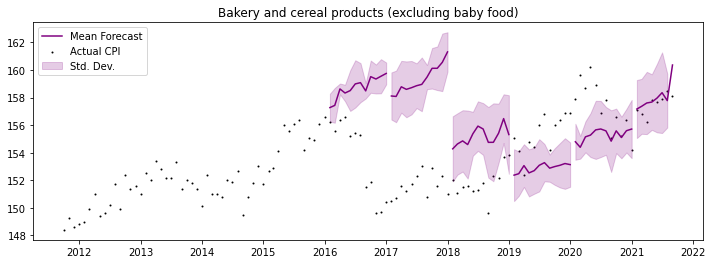

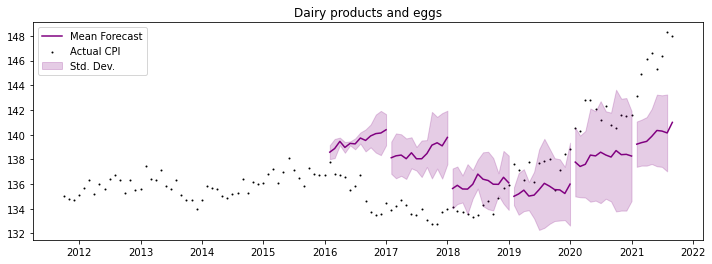

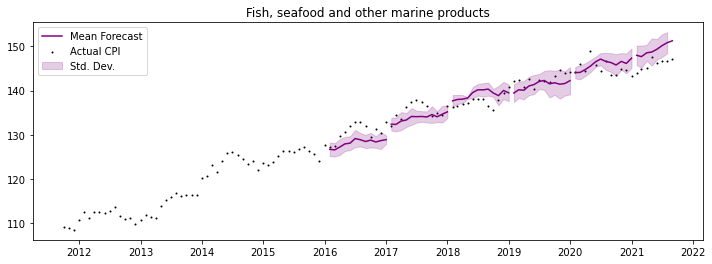

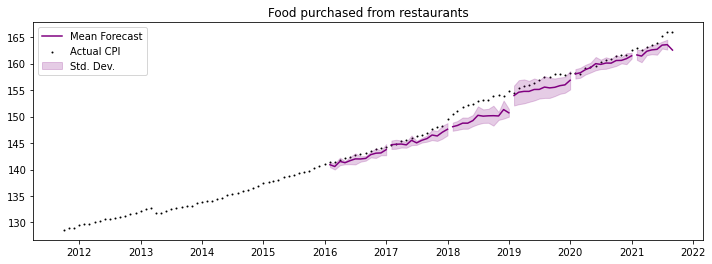

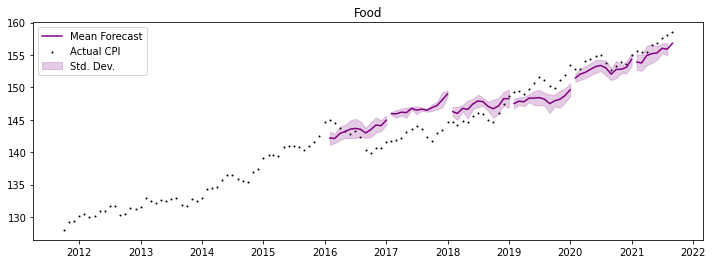

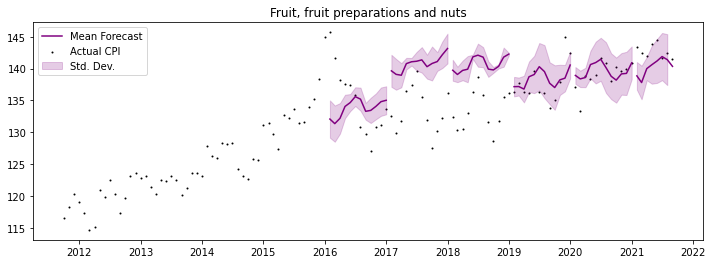

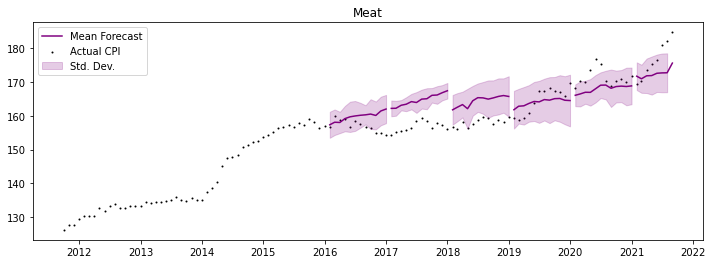

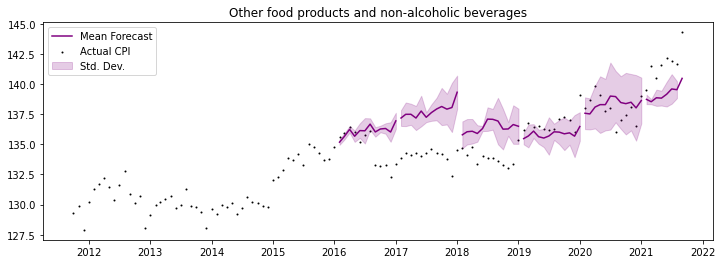

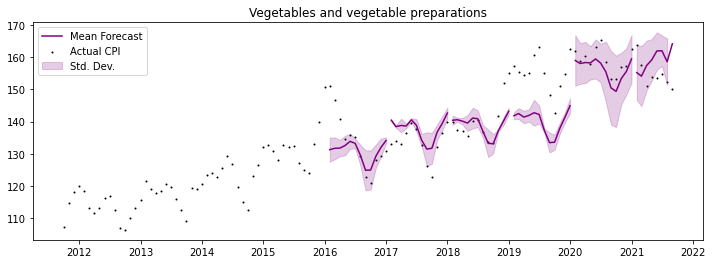

In [21]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=1, label="Actual CPI")

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, experiment_names, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index > pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index <= pd.to_datetime(date) + pd.DateOffset(months=18)]

        if d_index < 1:
            ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='purple', label='Mean Forecast')
            ax.fill_between(all_forecasts.index, all_forecasts.mean(axis=1) - all_forecasts.std(axis=1), all_forecasts.mean(axis=1) + all_forecasts.std(axis=1), alpha=0.2, color='purple', label='Std. Dev.')
        else:
            ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='purple')
            ax.fill_between(all_forecasts.index, all_forecasts.mean(axis=1) - all_forecasts.std(axis=1), all_forecasts.mean(axis=1) + all_forecasts.std(axis=1), alpha=0.2, color='purple')

    plt.title(category)
    plt.legend()
    plt.show()
